In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:
train = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")

train.head()


C:\Users\shravya\AppData\Local\Temp\ipykernel_2496\3668056252.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
df = pd.merge(train, store, on='Store', how='left')
df.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
# Convert Date
df['Date'] = pd.to_datetime(df['Date'])

# Remove days when store was closed
df = df[df['Open'] == 1]

# Fill missing values
df.fillna(0, inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 0 to 1017190
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        844392 non-null  float64     

In [6]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week


In [7]:
monthly_sales = (
    df
    .groupby(['Store', pd.Grouper(key='Date', freq='M')])['Sales']
    .sum()
    .reset_index()
)

monthly_sales.head()


C:\Users\shravya\AppData\Local\Temp\ipykernel_2496\2205167268.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(['Store', pd.Grouper(key='Date', freq='M')])['Sales']


,Store,Date,Sales
0,1,2013-01-31,128431
1,1,2013-02-28,125271
2,1,2013-03-31,145169
3,1,2013-04-30,118009
4,1,2013-05-31,118225


In [8]:
store_id = 1
store_data = monthly_sales[monthly_sales['Store'] == store_id]


In [9]:
prophet_df = store_data[['Date', 'Sales']].rename(
    columns={'Date': 'ds', 'Sales': 'y'}
)

prophet_df.head()


,ds,y
0,2013-01-31,128431
1,2013-02-28,125271
2,2013-03-31,145169
3,2013-04-30,118009
4,2013-05-31,118225


In [10]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.15
)

model.fit(prophet_df)


20:19:10 - cmdstanpy - INFO - Chain [1] start processing
20:19:12 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


C:\Users\shravya\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
38,2016-03-31,122719.320409,118200.302203,126577.571322
39,2016-04-30,90821.796666,85975.575837,95402.229024
40,2016-05-31,94934.771182,89403.647164,99950.863600
41,2016-06-30,81755.455645,75825.260159,87300.638847
42,2016-07-31,98488.121017,92078.905129,104728.923911


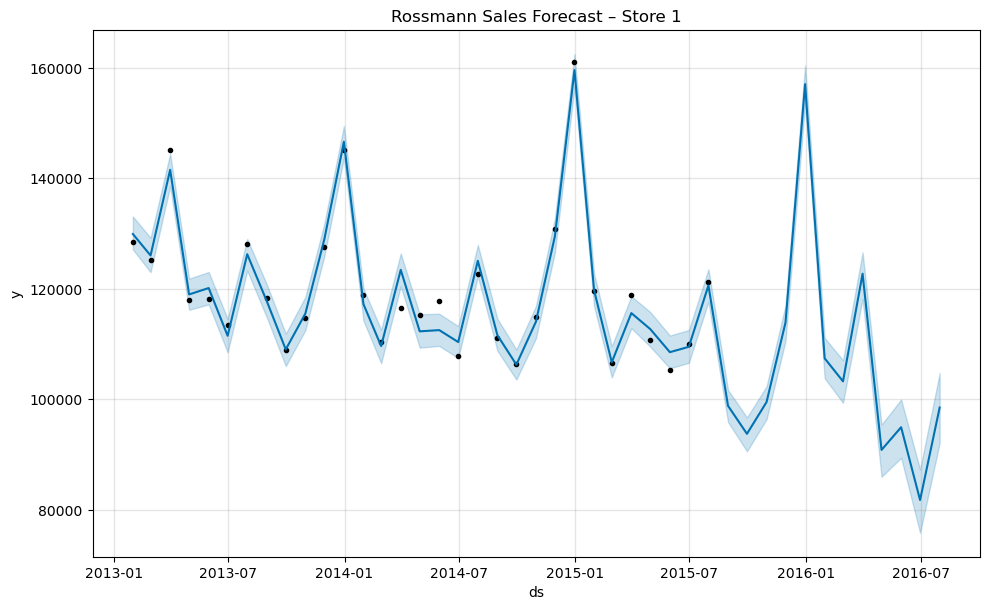

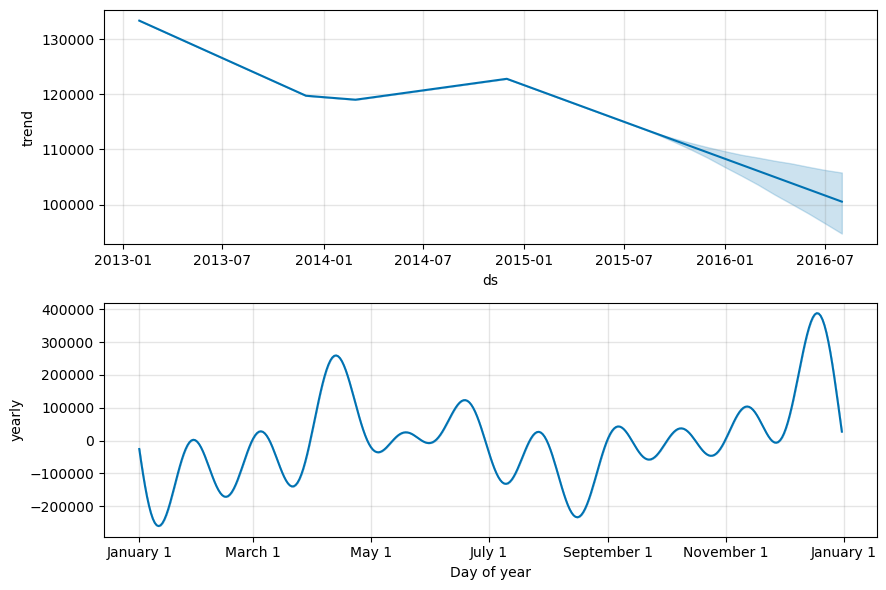

In [12]:
model.plot(forecast)
plt.title("Rossmann Sales Forecast – Store 1")
plt.show()

model.plot_components(forecast)
plt.show()


In [13]:
final_output = pd.merge(
    prophet_df,
    forecast[['ds', 'yhat']],
    on='ds',
    how='left'
)

final_output.rename(columns={
    'ds': 'Date',
    'y': 'Actual_Sales',
    'yhat': 'Forecast_Sales'
}, inplace=True)

final_output.head()


,Date,Actual_Sales,Forecast_Sales
0,2013-01-31,128431,129910.710318
1,2013-02-28,125271,126025.274816
2,2013-03-31,145169,141532.037414
3,2013-04-30,118009,118970.108949
4,2013-05-31,118225,120128.525788


In [14]:
final_output.to_csv("rossmann_sales_forecast_powerbi.csv", index=False)


In [1]:
import os
os.getcwd()


'C:\\Users\\shravya\\t1'

In [2]:
os.listdir()



['.ipynb_checkpoints',
 'Retail_Sales_Forecasting.ipynb',
 'rossmann_sales_forecast_powerbi.csv',
 'store.csv',
 'train.csv',
 'Untitled.ipynb']

In [3]:
import pandas as pd

# Load existing file
df = pd.read_csv("rossmann_sales_forecast_powerbi.csv")

# Convert Date
df['Date'] = pd.to_datetime(df['Date'])

# Add required columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# If single store (still acceptable for internship)
df['Store'] = 1

# Save again
df.to_csv("rossmann_sales_forecast_powerbi.csv", index=False)

df.head()

,Date,Actual_Sales,Forecast_Sales,Year,Month,Store
0,2013-01-31,128431,129910.710318,2013,1,1
1,2013-02-28,125271,126025.274816,2013,2,1
2,2013-03-31,145169,141532.037414,2013,3,1
3,2013-04-30,118009,118970.108949,2013,4,1
4,2013-05-31,118225,120128.525788,2013,5,1
